# Estación Vallecas

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

import warnings
warnings.filterwarnings('ignore')

In [2]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from itertools import product

In [3]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

In [4]:
df = pd.read_csv("../data/df_40.csv", index_col=0)
df.index = pd.to_datetime(df.index)

In [5]:
df.head()

,NO2
month,
2013-01-01,47.838710
2013-02-01,35.612903
2013-03-01,27.903226
2013-04-01,26.516129
2013-05-01,26.870968


### Estacionalidad

In [6]:
df2 = df.copy()

In [7]:
df2["año"] = df.index.year
df2["mes"] = df.index.month

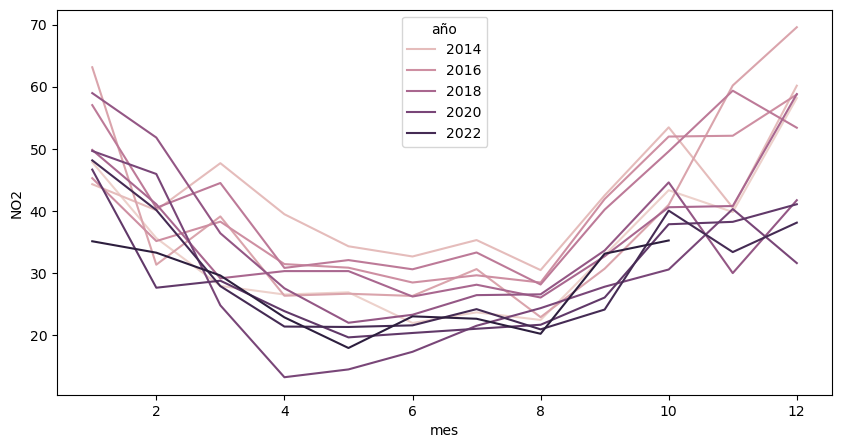

In [8]:
sns.lineplot(x = "mes", y = "NO2", hue = "año", data = df2);

### Estacionaridad

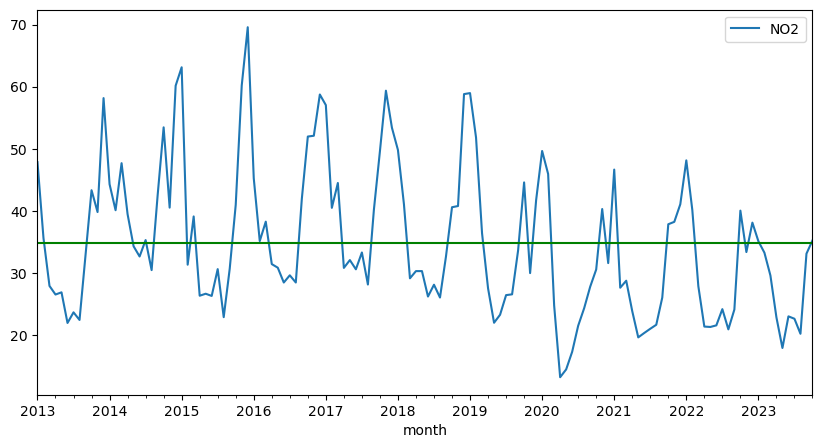

In [9]:
df.plot()
plt.axhline(df.NO2.mean(), c = "g");

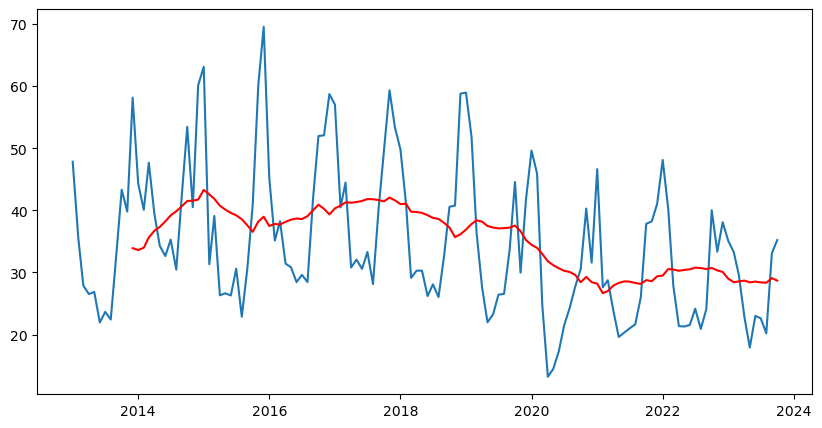

In [10]:
plt.plot(df["NO2"])
plt.plot(df.rolling(window= 12).mean(), c = "r");

### Test de Fuller

In [11]:
res = adfuller(df["NO2"])
res

(-0.552373899696157,
 0.8813845975842847,
 11,
 118,
 {'1%': -3.4870216863700767,
  '5%': -2.8863625166643136,
  '10%': -2.580009026141913},
 782.3257123701334)

In [12]:
print("AD Fuller Stats", res[0])
print("p-value", res[1])
print("Critical values")

for k, v in res[4].items():
    print(k, round(v, 2))

AD Fuller Stats -0.552373899696157
p-value 0.8813845975842847
Critical values
1% -3.49
5% -2.89
10% -2.58


*Datos no estacionarios. Su media y su varianza están en función del tiempo 🍋*

### Autocorrelación

In [13]:
for i in range(49):
    print(f"{i} mes Lag, {df['NO2'].autocorr(lag= i)}")

0 mes Lag, 0.9999999999999999
1 mes Lag, 0.7088457075487583
2 mes Lag, 0.43389729581930936
3 mes Lag, 0.15872806672106032
4 mes Lag, -0.1409576648684582
5 mes Lag, -0.3176185304819911
6 mes Lag, -0.3747773040411721
7 mes Lag, -0.35231900283661904
8 mes Lag, -0.17613088630908635
9 mes Lag, 0.12173622696118283
10 mes Lag, 0.3992097847607172
11 mes Lag, 0.6342854485111786
12 mes Lag, 0.7618989423655486
13 mes Lag, 0.6328580118128357
14 mes Lag, 0.38354175815096575
15 mes Lag, 0.09642424937499795
16 mes Lag, -0.2377695012176786
17 mes Lag, -0.4204064586785782
18 mes Lag, -0.4677170204070726
19 mes Lag, -0.40229675250678126
20 mes Lag, -0.18839924060521654
21 mes Lag, 0.10284959961611419
22 mes Lag, 0.3380689709958045
23 mes Lag, 0.6283882796123854
24 mes Lag, 0.7676955464031109
25 mes Lag, 0.6260153751061283
26 mes Lag, 0.39356967179311875
27 mes Lag, 0.09774854498889612
28 mes Lag, -0.22923368690685375
29 mes Lag, -0.42850816878368725
30 mes Lag, -0.494074027471478
31 mes Lag, -0.44498442

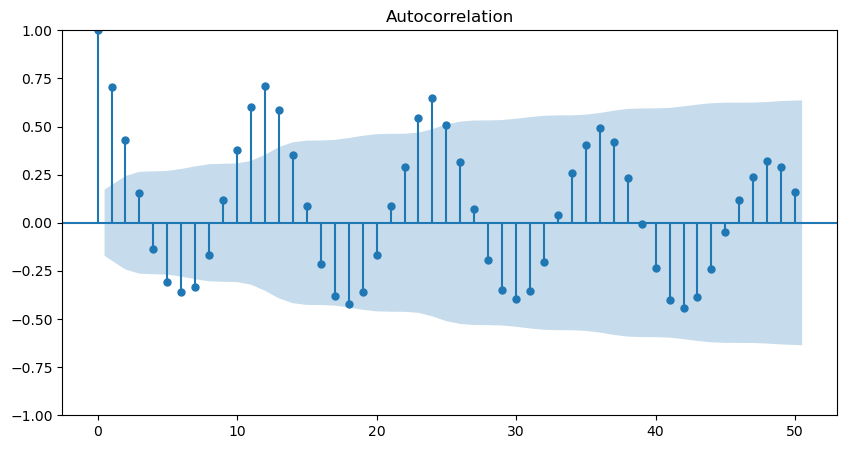

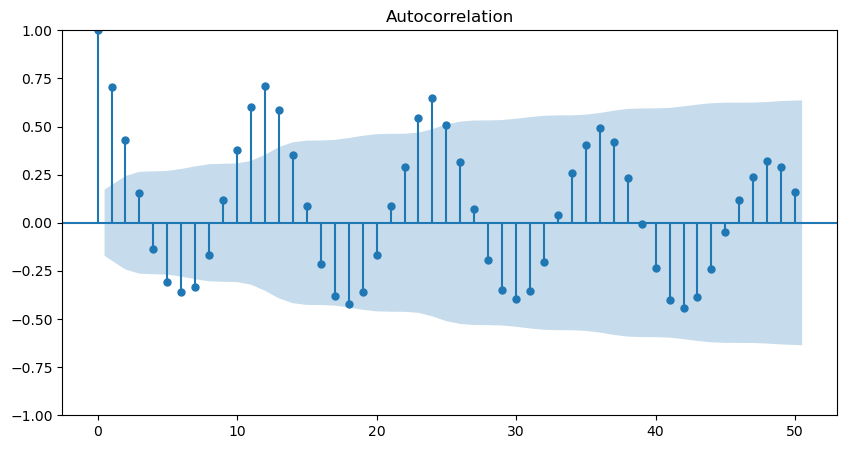

In [14]:
plot_acf(df, lags = 50)

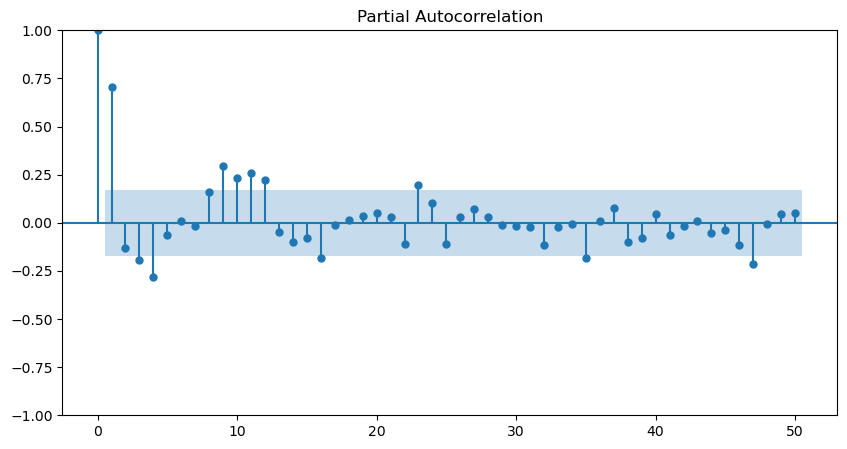

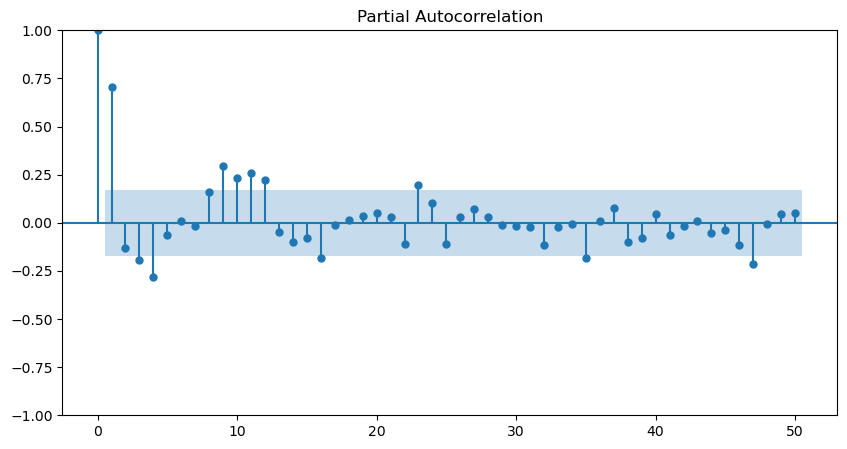

In [15]:
plot_pacf(df, lags = 50)

In [16]:
df.head()

,NO2
month,
2013-01-01,47.838710
2013-02-01,35.612903
2013-03-01,27.903226
2013-04-01,26.516129
2013-05-01,26.870968


In [17]:
df.shape

(130, 1)

In [18]:
df.isnull().sum()

NO2    0
dtype: int64

## SARIMA

In [19]:
y_test = df["NO2"][-30:]
y_train = df["NO2"][:-30]

In [20]:
ps = range(3)
ds = range(1,3)
qs = range(3)

parameters = list(product(ps,ds, qs))
print(parameters)

[(0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 2, 0), (0, 2, 1), (0, 2, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 2, 0), (1, 2, 1), (1, 2, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 2, 0), (2, 2, 1), (2, 2, 2)]


In [21]:
%%time

modelo=SARIMAX(endog=y_train, 
               exog=None,
               #order=(4, 1, 5),  # modelo arima
               seasonal_order=(3, 1, 3, 12) # modelo sarima, estacionalidad es el ultimo
              ).fit(disp=False)
                     
pred=modelo.predict(len(y_train), len(df)-1)  

error=(pred-y_test).abs().sum()/len(pred) 
print ('Error mae: ', error)


res=pd.DataFrame({'real':y_test, 'pred':pred, 'error':pred-y_test})
res

C:\Users\ccior\anaconda3\envs\proyecto\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ccior\anaconda3\envs\proyecto\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ccior\anaconda3\envs\proyecto\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Error mae:  3.389199056779205
CPU times: total: 2.11 s
Wall time: 5.79 s


,real,pred,error
2021-05-01,19.612903,21.537128,1.924225
2021-06-01,20.322581,21.783123,1.460542
2021-07-01,21.000000,24.566497,3.566497
2021-08-01,21.645161,25.944196,4.299034
2021-09-01,26.032258,33.214747,7.182489
2021-10-01,37.838710,41.082964,3.244254
2021-11-01,38.225806,35.415831,-2.809976
2021-12-01,41.064516,42.561836,1.497320
2022-01-01,48.129032,50.953814,2.824782
2022-02-01,40.129032,38.000567,-2.128465


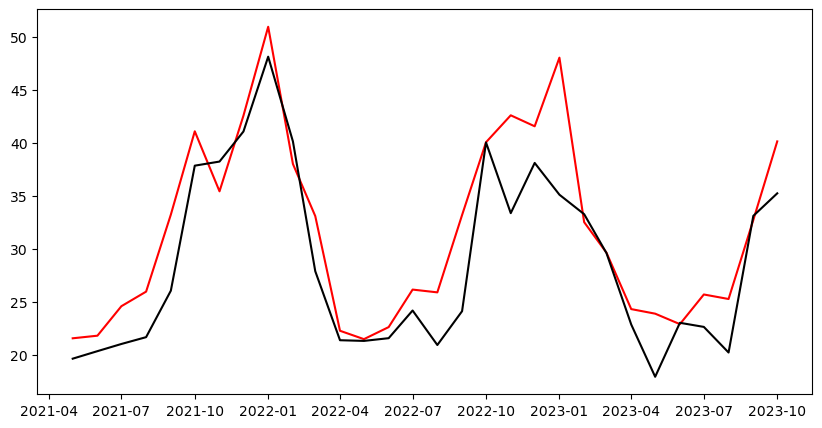

In [22]:
plt.plot(res["pred"], c = "r")
plt.plot(res["real"], c = "black");

In [23]:
pred_año = pd.DataFrame(modelo.predict(start = len(df), end = len(df) + 12))
pred_año

,predicted_mean
2023-11-01,41.603731
2023-12-01,48.996757
2024-01-01,50.731739
2024-02-01,37.500848
2024-03-01,35.469299
2024-04-01,27.410292
2024-05-01,25.214506
2024-06-01,24.774954
2024-07-01,27.569795
2024-08-01,26.475378


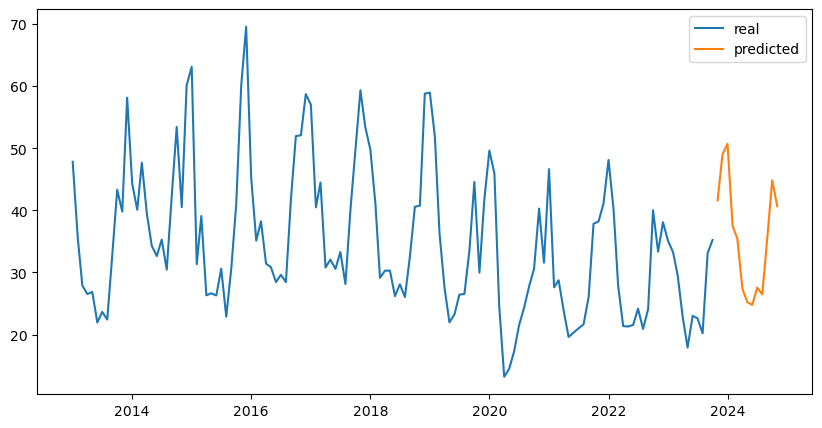

In [24]:
plt.plot(df)
plt.plot(pred_año)
plt.legend(["real", "predicted"]);

In [25]:
pred_año.mean()

predicted_mean    35.910659
dtype: float64